In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

import os
from keras.models import model_from_json 
import time

# GAN 모델을 돌리기 위한 GPU 셋팅

- 밑에 나오는 excuting gpu가 실행 결과

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
tf.device('/device:GPU:2')

# 모델 구축하기

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# 가중치 저장 함수
def save_weight_to_json(model):
  cur_dir = os.getcwd() # 현재 작업 디렉
  ckpt_dir = "checkpoints" # weight를 저장할 디렉토리
  file_name = "gan_weights.ckpt" # 저장 파일명
  dir = os.path.join(cur_dir, ckpt_dir) 
  os.makedirs(dir, exist_ok = True) # dir이라는 폴더를 만듬

  file_path = os.path.join(dir, file_name) #dir 경로 + 파일 이름의 파일 경로를 join함
  model.save_weights(file_path)

  model_json = model.to_json() # 모델 구조도 저장하여 model.json으로 저장
  with open("model.json", "w") as json_file : 
    json_file.write(model_json)

# 가중치 로드
def load_weight_to_json():
  json_file = open("model.json", "r")
  loaded_model_json = json_file.read() 
  json_file.close()

  loaded_model = model_from_json(loaded_model_json)

# 그래프를 생성하는 함수
def plotLoss(G_loss, D_loss, epoch):
  cur_dir = os.getcwd()
  loss_dir = "loss_graph"
  file_name = 'gan_loss_epoch_%d.png' % epoch
  dir = os.path.join(cur_dir, loss_dir) 
  os.makedirs(dir, exist_ok = True)

  file_path = os.path.join(dir, file_name)

  plt.figure(figsize=(10, 8))
  plt.plot(D_loss, label='Discriminitive loss')
  plt.plot(G_loss, label='Generative loss')
  plt.xlabel('BatchCount')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig(file_path)

# 이미지를 저장하는 함수
def sample_images(epoch, latent_dim = 128):
  cur_dir = os.getcwd()
  image_dir = "images"
  file_name = '%d.png' % epoch
  dir = os.path.join(cur_dir, image_dir) 
  os.makedirs(dir, exist_ok = True)

  file_path = os.path.join(dir, file_name)


  r, c = 5, 5
  noise = np.random.normal(0, 1, (r * c, latent_dim))
  gen_imgs = generator.predict(noise)

  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
      for j in range(c):
          axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
          axs[i,j].axis('off')
          cnt += 1
  fig.savefig(file_path)
  plt.close()

# 모델을 로드하는 함수
def load_model(model, model_path='saved_model/model.h5'):
  print('\nload model : \"{}\"'.format(model_path))
  model = tf.keras.models.load_model(model_path)

# 모델을 저장하는 함수
def save_model(model, model_path='saved_model/model.h5'):
  print('\nsave model : \"{}\"'.format(model_path))
  model.save(model_path)

In [ ]:
img_rows = 28 
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

z_dim = 128
batch_size = 100
learning_rate = 0.0001
n_hidden = 256

### 생성자

In [ ]:
def build_generator(img_shape, z_dim):
  model = Sequential()

  model.add(Dense(n_hidden, input_dim = z_dim)) # 인풋은 100 다음은 128개의 노드
  model.add(LeakyReLU(alpha = 0.01))
  model.add(Dense(28 * 28 * 1, activation="tanh")) # 128개의 노드 다음은 784개의 노드

  model.add(Reshape(img_shape))
  return model

### 판별자

In [ ]:
def build_discriminator(img_shape):
  model = Sequential()

  model.add(Flatten(input_shape = img_shape)) # 이미지 모양대로 입력받아서 폄
  model.add(Dense(n_hidden))
  model.add(LeakyReLU(alpha=0.01))
  model.add(Dense(1, activation="sigmoid"))

  return model

### 훈련 시작

In [ ]:
def build_gan(generator, discriminator):

    model = Sequential()

    # 생성자 -> 판별자로 연결된 모델
    model.add(generator)
    model.add(discriminator)

    return model

In [ ]:
discriminator = build_discriminator(img_shape)
discriminator.compile(loss="binary_crossentropy", # 맞다 아니다
                      optimizer=Adam(),
                      metrics=['accuracy'])

generator = build_generator(img_shape, z_dim)

discriminator.trainable = False # 생성자를 훈련하는 동안 판별자가 훈련되지 않도록 동결 
# -> 참 신기한게  train 함수에 생성자, 판별자 생성을 넣은 것도 아니고 .trainable = False를 밖에서 그냥 한 건데 훈련시 동결이 된대 이게 라이브러리 메소드의 힘이다!!

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [ ]:
def train(total_epoch, batch_size, sample_interval):

    # MNIST 데이터셋 로드
    (X_train, _), (_, _) = mnist.load_data()

    # [0, 255] 흑백 픽셀 값을 [-1, 1] 사이로 스케일 조정 ∵ 생성자의 끝이 tanh라서 판별자의 모든 입력 범위를 맞춰야함
    X_train = X_train / 127.5 - 1.0 # -> 0 / 127.5 = 0 > 0-1 = '-1'/ 255 / 127.5 = 2 > 2-1 = '1'


    X_train = np.expand_dims(X_train, axis=3) #60000, 28, 28, 1

    # 진짜 이미지 레이블: 모두 1
    real = np.ones((batch_size, 1))

    # 가짜 이미지 레이블: 모두 0
    fake = np.zeros((batch_size, 1))

    D_loss_list = []
    G_loss_list = []
    for iteration in range(total_epoch):

        # -------------------------
        #  판별자 훈련
        # -------------------------

        # 진짜 이미지에서 랜덤 배치 가져오기
        # np.random.randint(최소값, 미만값, size) - 랜덤한 정수 추출
        idx = np.random.randint(0, X_train.shape[0], batch_size) # 0 ~ 60000 사이의 수에서 128개의 수를 뽑음
        imgs = X_train[idx] # 그것을 fancy 인덱싱하면 랜덤으로 뽑은 수(행)에 해당하는 mnist 이미지가 생김








        # 가짜 이미지 배치 생성
        z = np.random.normal(0, 1, (batch_size, z_dim)) #0~1수 128행 100열을 만듬
        gen_imgs = generator.predict(z) #이게 왜 되지? -> 시퀀셜 모델일 뿐이니 predict 인정 model.predict임

        # 판별자 훈련
        d_loss_real = discriminator.train_on_batch(imgs, real) # 이게 케라스 라이브러임 fit과 같은 거임 와,,,,

        # gen_imgs는 어딨음? 밑에 있음 ㅋㅋ
        # 보다시키 train은 하나지만 d를 두번 훈련하고 그때 실제 데이터에는 1 가짜에는 0을 주는 것은 첫걸음과 동일
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) 
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)





        # ---------------------
        #  생성자 훈련
        # ---------------------

        # 가짜 이미지 배치 생성
        z = np.random.normal(0, 1, (batch_size, z_dim)) # 가짜 이미지에 넣을 크기 100(z_dim = 100차원)의 벡터를 생성
        gen_imgs = generator.predict(z)

        # 생성자 훈련
        g_loss = gan.train_on_batch(z, real) # 생성자는 가짜가 1이라고 말함 -> gan으로 하는 이유는 생성자는 판별자도 필요함 = 판별자의 오차로 생성자를 훈련하니

        G_loss_list.append(g_loss)
        D_loss_list.append(d_loss)
        print ("%d [D loss: %lf, acc.: %.2lf%%] [G loss: %lf]" % (iteration, d_loss, 100*d_loss, g_loss))

        if total_epoch % sample_interval == 0:
          sample_images(total_epoch)
    plotLoss(G_loss_list, D_loss_list, total_epoch)



4/4 [==============================] - 0s 2ms/step
0 [D loss: 0.012680, acc.: 1.27%] [G loss: 3.967807]
4/4 [==============================] - 0s 2ms/step
1 [D loss: 0.013657, acc.: 1.37%] [G loss: 4.176181]
4/4 [==============================] - 0s 2ms/step
2 [D loss: 0.010991, acc.: 1.10%] [G loss: 4.560862]
4/4 [==============================] - 0s 2ms/step
3 [D loss: 0.008110, acc.: 0.81%] [G loss: 5.021807]
4/4 [==============================] - 0s 2ms/step
4 [D loss: 0.011114, acc.: 1.11%] [G loss: 4.934433]
4/4 [==============================] - 0s 2ms/step
5 [D loss: 0.011008, acc.: 1.10%] [G loss: 4.564358]
4/4 [==============================] - 0s 2ms/step
6 [D loss: 0.009562, acc.: 0.96%] [G loss: 4.715455]
4/4 [==============================] - 0s 2ms/step
7 [D loss: 0.009351, acc.: 0.94%] [G loss: 4.830019]
4/4 [==============================] - 0s 2ms/step
8 [D loss: 0.009304, acc.: 0.93%] [G loss: 4.658870]
4/4 [==============================] - 0s 2ms/step
9 [D loss: 0.

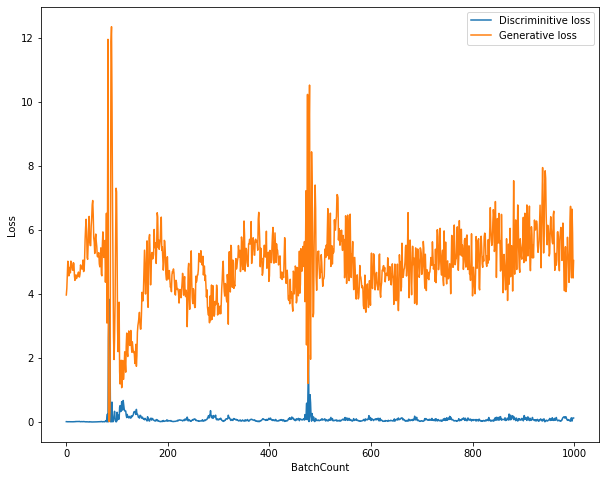

In [ ]:
# 하이퍼파라미터 설정
total_epoch = 1000
sample_interval = 100 # 1000에폭에 저장해라

# 지정된 반복 횟수만큼 GAN 훈련
train(total_epoch, batch_size, sample_interval)

In [ ]:
save_weight_to_json(gan)
save_model(gan)


save model : "saved_model/model.h5"


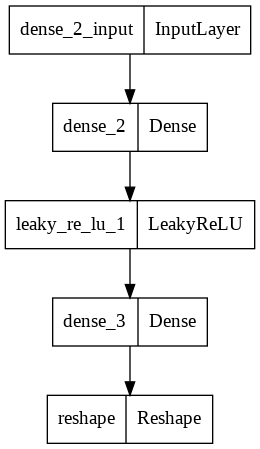

In [ ]:
plot_model(generator, to_file='model.png')

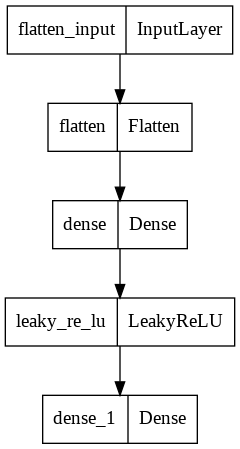

In [ ]:
plot_model(discriminator, to_file='model.png')

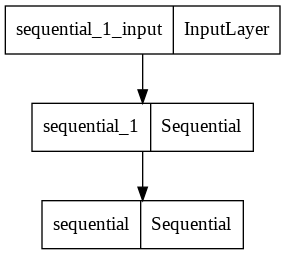

In [ ]:
plot_model(gan, to_file='model.png')